In [1]:
import GenEvents as ge
import PlotEvents as pe
import EventData as ed
import Params as ps

In [2]:
import numpy as np
import tqdm 
import math

import snntorch as snn
import torch
import torch.nn as nn

import snntorch.spikeplot as splt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from snntorch import surrogate
import snntorch.functional as SF
import torch.nn.functional as F

from snntorch import spikegen

import matplotlib.pyplot as plt
import snntorch.spikeplot as splt

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
num_events = 100000
num_events_test = 6000

events_arr, muon_list, max_n = ge.generate_noisy_evts(num_events, noise_frac=0.4, bkg_frac=0.5)
events_arr_test, muon_list_test, max_n_test = ge.generate_noisy_evts(num_events_test, noise_frac=0.4, bkg_frac=0.5)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:07<00:00, 783.79it/s]


In [4]:
def get_data(muon_list):
    data = np.zeros(shape=(len(muon_list), 1,ps.NLAYERS, ps.NWIRES), dtype=np.float32)
    for i, evt in tqdm.tqdm(enumerate(muon_list)):
        for hit in evt:
            layer, wire = hit['layer']-1, hit['wire_num']-1
            
            data[i, 0,layer, wire] = 1

    return data

def get_target(muon_list):
    target = np.zeros(shape=(len(muon_list), 1,ps.NLAYERS, ps.NWIRES), dtype=np.float32)
    for i, evt in tqdm.tqdm(enumerate(muon_list)):
        for hit in evt:
            layer, wire = hit['layer']-1, hit['wire_num']-1

            if hit['signal'] == True:
                target[i, 0,layer, wire] = 1

    return target

# transform each event (muon_hits list) to np.array of fixed size
def convert_to(muon_list, size, target_dtype=np.int16,
               features=['layer', 'wire_num', 'bx', 't0']):
    padded_array = np.zeros(shape=(len(muon_list), size, len(features)), dtype=target_dtype)
    for i, muon_hits in enumerate(muon_list):
        for j, hit in enumerate(muon_hits):
            for k, f in enumerate(features):
                padded_array[i,j,k] = hit[f]  # BEWARE: implicit type conversions going on here

    return padded_array

In [5]:
class CustomDataset(Dataset):
    def __init__(self, input_data, target, window):
        
        self.data = input_data
        self.labels = target
        self.window = window

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = {'data': torch.tensor(self.data[idx],dtype=torch.float32), 
                  'label': torch.tensor(self.labels[idx],dtype=torch.float32),
                  "window":torch.tensor(self.window[idx],dtype=torch.float32)}  
        return sample

In [6]:
window = get_data(muon_list)
target = get_target(muon_list)

feature_list = ['layer', 'wire_num', 'bx', 't0', 'signal']
muon_array = convert_to(muon_list, size=max_n, target_dtype=np.float32,
                        features=feature_list)

100000it [00:00, 440598.52it/s]
100000it [00:00, 512794.36it/s]


In [7]:
# Create your dataset with 1000 samples
train_dataset = CustomDataset(muon_array,target,window)

In [8]:
# Create a DataLoader
batch_size = 100
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

## SpikeGen

In [22]:
def custom_spikegen(data,reference, num_step=40):
    
    ref = reference.squeeze()
    spike_data = torch.zeros(size=(num_step,batch_size,ps.NLAYERS,ps.NWIRES), dtype=data.dtype)
    
    for n_batch, evt in enumerate(data):
    
        notZeroBx = evt[evt[:,2] > 0][:,2].numpy()
        if len(notZeroBx) == 0:
            break
        
        startTime = min(500,min(notZeroBx))
            
        for hit in evt[evt[:,2] > 0]:
            
            bx = int(hit[2])
            time = int(bx - startTime)
            
            layer = int(hit[0])
            wire = int(hit[1])
            
            if ref[n_batch][layer-1][wire-1] == 1:
                spike_data[time, n_batch, layer-1, wire-1] = 1
            
            else:
                spike_data[time, n_batch, layer-1, wire-1] = 0.3
                
                
    return spike_data 

## Network

In [23]:
# Network Architecture
num_inputs = ps.NLAYERS*ps.NWIRES
num_hidden = 100
num_outputs = 2*num_inputs

# Temporal Dynamics
num_steps = 40
beta = 0.8
alpha = 0.5

threshold = 0.05

In [24]:
# Define the CNN architecture
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(16, 1, kernel_size=3, stride=1, padding=1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.sigmoid(x)
        
        return x

class Net(nn.Module):
    """Simple spiking neural network in snntorch."""

    def __init__(self, input_feat, hidden,out_feat,timesteps):
        super().__init__()
        
        self.input_feat = input_feat # number of input neurons 
        self.hidden = hidden # number of hidden neurons
        self.out_feat = out_feat # number of output neurons
        
        self.timesteps = timesteps # number of time steps to simulate the network
        spike_grad = surrogate.fast_sigmoid() # surrogate gradient function
        
        self.fc_in = nn.Linear(in_features=self.input_feat, out_features=self.hidden)
        self.lif_in = snn.Leaky(beta=beta,spike_grad=spike_grad,threshold=0.9)
        
        self.fc_out = nn.Linear(in_features=self.hidden, out_features=self.out_feat)
        self.lif_out = snn.Leaky(beta=beta,spike_grad=spike_grad,threshold=0.9)
    
    def forward(self, x):
        """Forward pass for several time steps."""

        # Initalize membrane potential
        mem1 = self.lif_in.init_leaky()
        mem2 = self.lif_out.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        # Loop over 
        for step in range(self.timesteps):
                
            cur1 = self.fc_in(x[step])
            spk1, mem1 = self.lif_in(cur1, mem1)
            cur2 = self.fc_out(spk1)
            spk2, mem2 = self.lif_out(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

In [25]:
class Multi_loss(nn.Module):
    def __init__(self, n_classes, loss_func):
        super(Multi_loss, self).__init__()
        self.n_classes = n_classes
        self.loss = loss_func

    def forward(self, inputs, targets):
        loss = 0
        for i in range(inputs.shape[-1]//self.n_classes):
            loss += self.loss(inputs[:, :, i*self.n_classes:(i+1)*self.n_classes],
                              targets[:, i])
        return loss

In [26]:
# Create the CNN model
cnn = CNN()
snnNetwork = Net(num_inputs, num_hidden, num_outputs, num_steps)

In [27]:
num_epochs = 5

loss_histCNN = []
loss_histSNN = []

# Define the loss function and optimizer
criterionCNN = nn.BCELoss()
optimizerCNN = torch.optim.Adam(cnn.parameters(), lr=0.001)

criterionSNN = Multi_loss(2, SF.ce_count_loss())
optimizerSNN = torch.optim.Adam(snnNetwork.parameters(), lr=5e-4, betas=(0.9, 0.999))

iter_counter = 0
# Training loop using DataLoader
for epoch in range(num_epochs):
    batch_counter = 0
    for batch in train_dataloader:
        
        data_it = batch['data']
        target = batch['label']
        inputs = batch['window']
        
        ###########
        ### CNN ###
        ###########
        
        cnn.train()
        
        # Forward pass
        outputs = cnn(inputs)
        outputs = torch.where(outputs < 0.05, torch.tensor(0,dtype=torch.float32), torch.tensor(1,dtype=torch.float32))
        
        # Compute the loss
        lossCNN = criterionCNN(outputs.requires_grad_(True), target)
        
        # Backward pass and optimization
        optimizerCNN.zero_grad()
        lossCNN.backward()
        optimizerCNN.step()

        # Store loss history for future plotting
        loss_histCNN.append(lossCNN.item())
        
        ###########
        ### SNN ###
        ###########
        
        snnNetwork.train()
        
        # create spike train
        spike_in = custom_spikegen(data_it, outputs,num_steps)
        spike_in = spike_in

        # forward pass
        spk_rec, mem_rec = snnNetwork(spike_in.view(num_steps, batch_size, -1))
        snnTRG = target.squeeze().type(torch.LongTensor)
        
         # Compute the loss
        loss_valSNN = criterionSNN(spk_rec, snnTRG.view(batch_size, -1))
        
        # Backward pass and optimization
        optimizerSNN.zero_grad()
        loss_valSNN.backward()
        optimizerSNN.step()

        # Store loss history for future plotting
        loss_histSNN.append(loss_valSNN.item())
        
        if iter_counter % 50 == 0:
            print("Epoch:",epoch)
            print("Batch:",batch_counter)
            print("Iteration:",iter_counter)
            print("Loss CNN:",lossCNN.item())
            print("Loss SNN:",loss_valSNN.item(),"\n")
            
            
        batch_counter += 1
        iter_counter += 1

Epoch: 0
Batch: 0
Iteration: 0
Loss CNN: 88.3125
Loss SNN: 11.028179168701172 

Epoch: 0
Batch: 50
Iteration: 50
Loss CNN: 88.0
Loss SNN: 9.123223304748535 

Epoch: 0
Batch: 100
Iteration: 100
Loss CNN: 90.25
Loss SNN: 5.2297282218933105 

Epoch: 0
Batch: 150
Iteration: 150
Loss CNN: 86.8125
Loss SNN: 5.891636848449707 

Epoch: 0
Batch: 200
Iteration: 200
Loss CNN: 88.875
Loss SNN: 5.064524173736572 

Epoch: 0
Batch: 250
Iteration: 250
Loss CNN: 88.8125
Loss SNN: 4.668607711791992 

Epoch: 0
Batch: 300
Iteration: 300
Loss CNN: 87.9375
Loss SNN: 4.107809066772461 

Epoch: 0
Batch: 350
Iteration: 350
Loss CNN: 89.8125
Loss SNN: 3.5184106826782227 

Epoch: 0
Batch: 400
Iteration: 400
Loss CNN: 89.375
Loss SNN: 2.6502130031585693 

Epoch: 0
Batch: 450
Iteration: 450
Loss CNN: 88.25
Loss SNN: 2.2847578525543213 

Epoch: 0
Batch: 500
Iteration: 500
Loss CNN: 88.375
Loss SNN: 2.2647674083709717 

Epoch: 0
Batch: 550
Iteration: 550
Loss CNN: 88.6875
Loss SNN: 2.1113598346710205 

Epoch: 0
Batc

Epoch: 4
Batch: 950
Iteration: 4950
Loss CNN: 87.6875
Loss SNN: 0.7566770315170288 



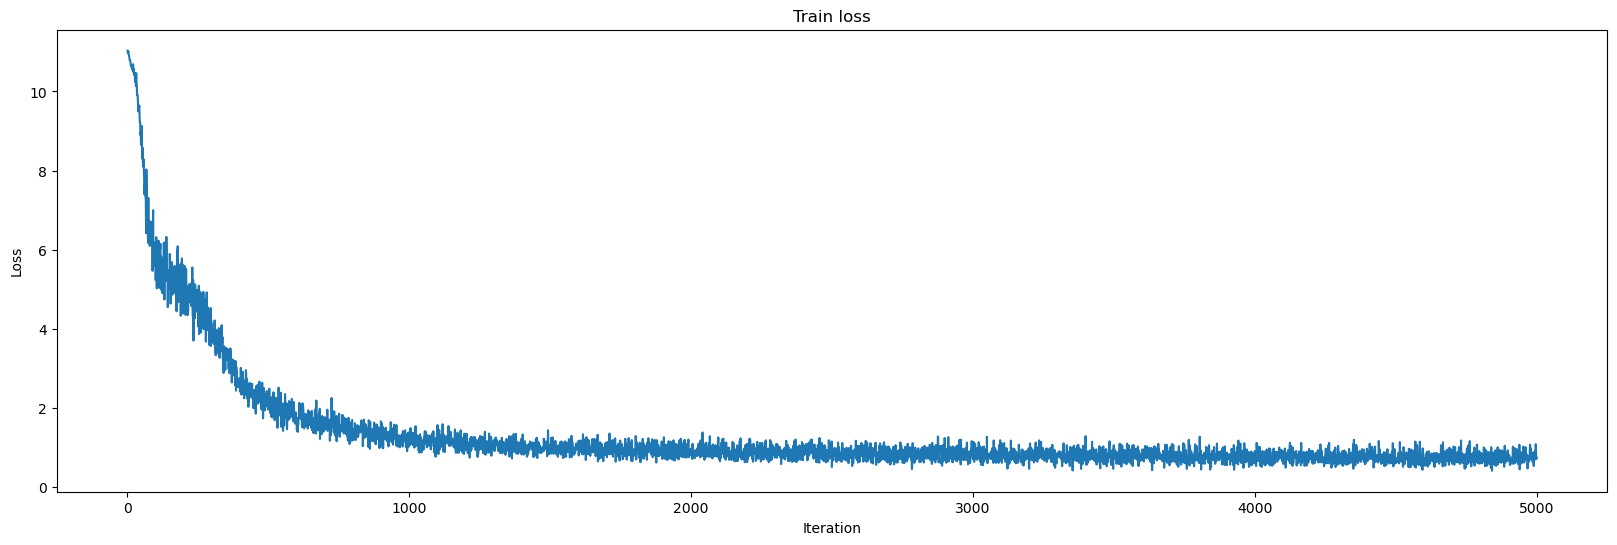

In [28]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(20, 6))
plt.plot(loss_histSNN)
plt.plot(loss_histCNN)
plt.title("Train loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
#plt.yscale("log")
plt.show()

In [29]:
def print_accuracy(Cnet,Snet,dataLoader):
    with torch.no_grad():
        Cnet.eval()
        Snet.eval()
        
        correct = 0
        total = 0
        for batch in dataLoader:
        
            data_it = batch['data']
            target = batch['label']
            inputs = batch['window']
            
            # Forward pass CNN
            outputs = Cnet(inputs)
            outputs = torch.where(outputs < 0.05, torch.tensor(0,dtype=torch.float32), torch.tensor(1,dtype=torch.float32))
        
            
            # create spike train
            spike_in = custom_spikegen(data_it, outputs,num_steps)
            
            # forward pass
            spk, _ = Snet(spike_in.view(num_steps, batch_size, -1))
            snnTRG = target.squeeze().type(torch.LongTensor)
            
            spk_count = spk.sum(dim=0).view(batch_size, ps.NLAYERS*ps.NWIRES, -1)
            _,flat_target = spk_count.max(2)
            out_target = flat_target.view(batch_size, ps.NLAYERS, -1)
            
            batch_len = data_it.size(0)
            total += batch_len
            for i in range(batch_size):
                correct += torch.sum((out_target[i] == snnTRG[i]).all())

            
    print(f"Total correctly classified events: {correct}/{total}")
    print(f"Accuracy: {100 * correct /total :.2f}%")

In [30]:
window_test = get_data(muon_list_test)
target_test = get_target(muon_list_test)

feature_list = ['layer', 'wire_num', 'bx', 't0', 'signal']
muon_array_test = convert_to(muon_list_test, size=max_n, target_dtype=np.float32,
                        features=feature_list)

# Create your dataset with 1000 samples
test_dataset = CustomDataset(muon_array_test,target_test,window_test)

# Create a DataLoader
batch_size = 100
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print_accuracy(cnn,snnNetwork,test_dataloader)

6000it [00:00, 295290.34it/s]
6000it [00:00, 235562.27it/s]


Total correctly classified events: 4871/6000
Accuracy: 81.18%


## Block NN

### Convolutional block

In [31]:
class CNNblock(nn.Module):
    def __init__(self,threshold):
        super(CNNblock,self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(16, 1, kernel_size=3, stride=1, padding=1)
        self.sigmoid = nn.Sigmoid()
        
        self.threshold = threshold
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.sigmoid(x)
        
        x = torch.where(x < self.threshold, torch.tensor(0,dtype=torch.float32), torch.tensor(1,dtype=torch.float32)).requires_grad_(True)
        
        return x

### Spike block

In [32]:
class SNNblock(nn.Module):
    """Simple spiking neural network in snntorch."""

    def __init__(self, input_feat, hidden,out_feat,timesteps):
        super(SNNblock,self).__init__()
        
        self.input_feat = input_feat # number of input neurons 
        self.hidden = hidden # number of hidden neurons
        self.out_feat = out_feat # number of output neurons
        
        self.timesteps = timesteps # number of time steps to simulate the network
        spike_grad = surrogate.fast_sigmoid() # surrogate gradient function
        
        self.fc_in = nn.Linear(in_features=self.input_feat, out_features=self.hidden)
        self.lif_in = snn.Leaky(beta=beta,spike_grad=spike_grad,threshold=0.9)
        
        self.fc_out = nn.Linear(in_features=self.hidden, out_features=self.out_feat)
        self.lif_out = snn.Leaky(beta=beta,spike_grad=spike_grad,threshold=0.9)
    
    def forward(self, x):
        """Forward pass for several time steps."""

        # Initalize membrane potential
        mem1 = self.lif_in.init_leaky()
        mem2 = self.lif_out.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        # Loop over 
        for step in range(self.timesteps):
                
            cur1 = self.fc_in(x[step])
            spk1, mem1 = self.lif_in(cur1, mem1)
            cur2 = self.fc_out(spk1)
            spk2, mem2 = self.lif_out(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

### Complete network

In [39]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel,self).__init__()
        self.conv_block = CNNblock(0.03)
        self.SNNblock = SNNblock(num_inputs, num_hidden, num_outputs, num_steps)

    def forward(self, x):
        
        outCNN = self.conv_block(x['window'])
        spike_in = custom_spikegen(x['data'], outCNN,num_steps)
        
        spk2_rec,mem2_rec = self.SNNblock(spike_in.view(num_steps, batch_size, -1))
        return spk2_rec,mem2_rec

In [40]:
def print_accuracy_mixedNN(network,dataLoader):
    with torch.no_grad():
        network.eval()
        
        correct = 0
        total = 0
        for batch in dataLoader:
        
            # Forward pass
            spk, _ = network(batch)
            snnTRG = batch["label"].squeeze().type(torch.LongTensor)
            
            spk_count = spk.sum(dim=0).view(batch_size, ps.NLAYERS*ps.NWIRES, -1)
            _,flat_target = spk_count.max(2)
            out_target = flat_target.view(batch_size, ps.NLAYERS, -1)
            
            batch_len = data_it.size(0)
            total += batch_len
            for i in range(batch_size):
                correct += torch.sum((out_target[i] == snnTRG[i]).all())

            
    print(f"Total correctly classified events: {correct}/{total}")
    print(f"Accuracy: {100 * correct /total :.2f}%")

#### Performance

In [41]:
model = MyModel()

In [42]:
num_epochs = 5
loss_hist = []

# Define the loss function and optimizer
criterion = Multi_loss(2, SF.ce_count_loss())
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, betas=(0.9, 0.999))

iter_counter = 0
# Training loop using DataLoader
for epoch in range(num_epochs):
    batch_counter = 0
    for batch in train_dataloader:
        
        model.train()

        # forward pass
        spk_rec, mem_rec = model(batch)
        snnTRG = batch["label"].squeeze().type(torch.LongTensor)
        
         # Compute the loss
        loss_val = criterion(spk_rec, snnTRG.view(batch_size, -1))
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())
        
        if iter_counter % 50 == 0:
            print("Epoch:",epoch)
            print("Batch:",batch_counter)
            print("Iteration:",iter_counter)
            print("Loss:",loss_val.item(),"\n")
            
            
        batch_counter += 1
        iter_counter += 1

Epoch: 0
Batch: 0
Iteration: 0
Loss: 11.08655834197998 

Epoch: 0
Batch: 50
Iteration: 50
Loss: 10.300896644592285 

Epoch: 0
Batch: 100
Iteration: 100
Loss: 7.299820899963379 

Epoch: 0
Batch: 150
Iteration: 150
Loss: 5.2161149978637695 

Epoch: 0
Batch: 200
Iteration: 200
Loss: 4.997422218322754 

Epoch: 0
Batch: 250
Iteration: 250
Loss: 5.1799750328063965 

Epoch: 0
Batch: 300
Iteration: 300
Loss: 4.587048530578613 

Epoch: 0
Batch: 350
Iteration: 350
Loss: 3.6949539184570312 

Epoch: 0
Batch: 400
Iteration: 400
Loss: 2.9729726314544678 

Epoch: 0
Batch: 450
Iteration: 450
Loss: 2.2952651977539062 

Epoch: 0
Batch: 500
Iteration: 500
Loss: 2.3385512828826904 

Epoch: 0
Batch: 550
Iteration: 550
Loss: 2.110502004623413 

Epoch: 0
Batch: 600
Iteration: 600
Loss: 2.015789270401001 

Epoch: 0
Batch: 650
Iteration: 650
Loss: 1.3429023027420044 

Epoch: 0
Batch: 700
Iteration: 700
Loss: 1.4736524820327759 

Epoch: 0
Batch: 750
Iteration: 750
Loss: 1.5231581926345825 

Epoch: 0
Batch: 800


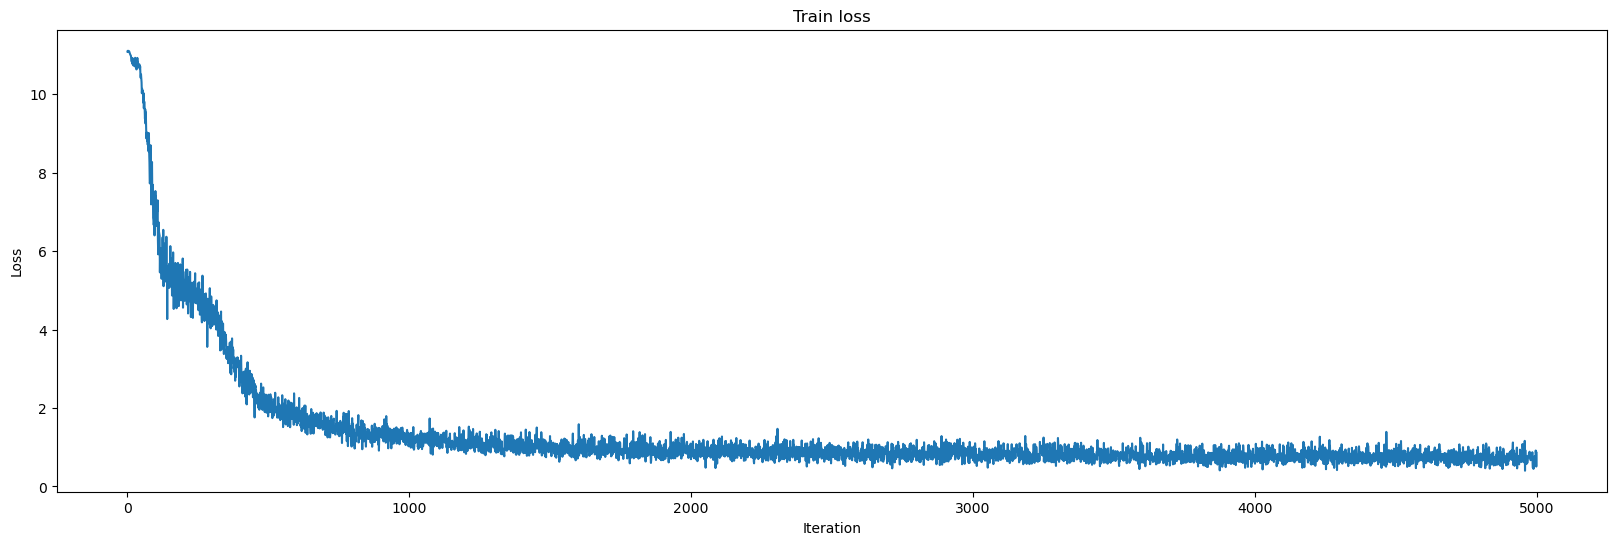

In [43]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(20, 6))
plt.plot(loss_hist)
plt.title("Train loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
#plt.yscale("log")
plt.show()

In [44]:
print_accuracy_mixedNN(model,test_dataloader)

Total correctly classified events: 4790/6000
Accuracy: 79.83%
